In [1]:
import pandas as pd
import numpy as np

# visualization
import matplotlib.pyplot as plt
import seaborn as sns

# model
from sklearn.linear_model import LogisticRegressionCV
from sklearn.cross_validation import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, roc_curve

/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


# Conversion rate 

***

## Objective

- predict conversion rate
- recommend ways to improve conversion rate

## Background

We have data about users who hit our site: whether they converted or not as well as some of
their characteristics such as their country, the marketing channel, their age, whether they are
repeat users and the number of pages visited during that session (as a proxy for site
activity/time spent on site).

In [2]:
conversion_data = pd.read_csv("conversion_data.csv")

In [3]:
conversion_data.head()

,country,age,new_user,source,total_pages_visited,converted
0,UK,25,1,Ads,1,0
1,US,23,1,Seo,5,0
2,US,28,1,Seo,4,0
3,China,39,1,Seo,5,0
4,US,30,1,Seo,6,0


In [4]:
conversion_data.describe();

In [5]:
# there's a max age of 123, need to remove this outlier
conversion_data = conversion_data[conversion_data.age < 100]

In [6]:
conversion_data.describe();

In [7]:
for column in conversion_data.columns:
    print (column)
    

country
age
new_user
source
total_pages_visited
converted


## Look at the conversion rate by countries

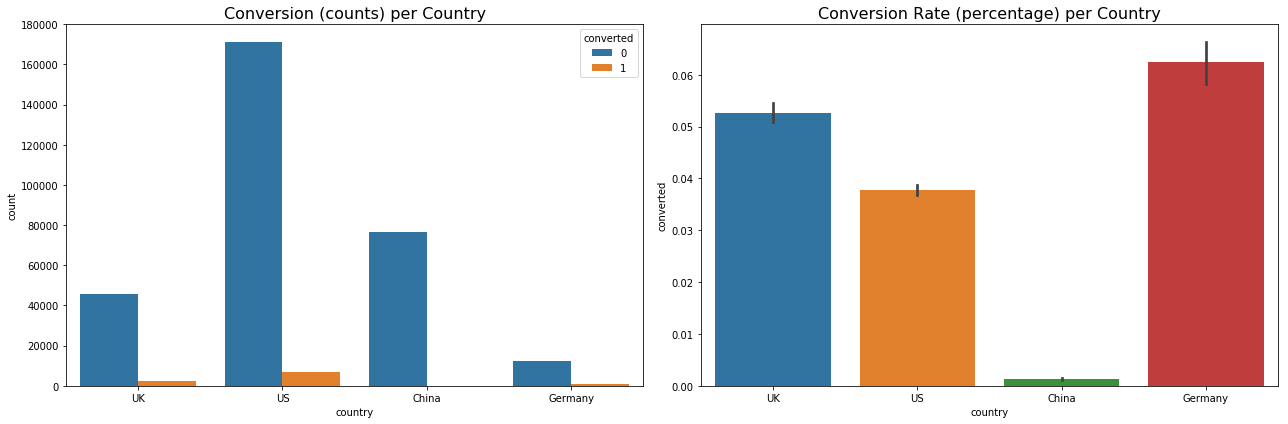

In [106]:
# create a fig with 1 row and 2 colns
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(18, 6))
sns.countplot(x='country', hue='converted', data = conversion_data, ax = ax[0])
ax[0].set_title('Conversion (counts) per Country', fontsize=16)
sns.barplot(x='country', y='converted', data=conversion_data, ax= ax[1])
ax[1].set_title('Conversion Rate (percentage) per Country', fontsize=16)
plt.tight_layout()
plt.show()

## Look at the conversion rate by age

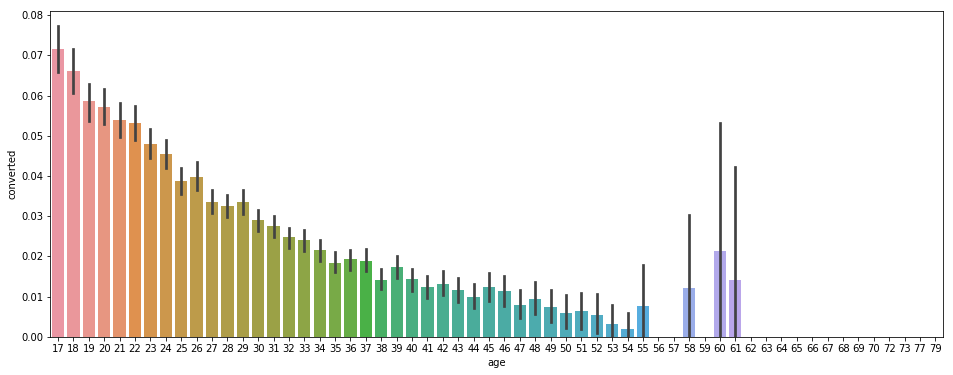

In [9]:
plt.figure(figsize=(16, 6))
sns.barplot(x='age', y='converted', data=conversion_data);

Younger people have a higher rate of conversion

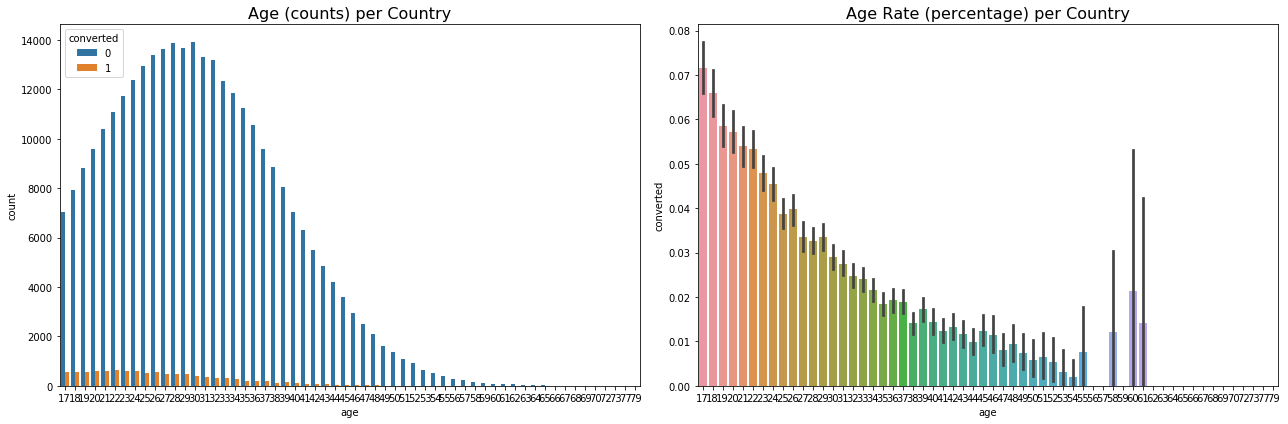

In [107]:
# create a fig with 1 row and 2 colns
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(18, 6))
sns.countplot(x='age', hue='converted', data = conversion_data, ax = ax[0])
ax[0].set_title('Age (counts) per Country', fontsize=16)
sns.barplot(x='age', y='converted', data=conversion_data, ax= ax[1])
ax[1].set_title('Age Rate (percentage) per Country', fontsize=16)
plt.tight_layout()
plt.show()

## Look at the conversion rate by total_pages_visited

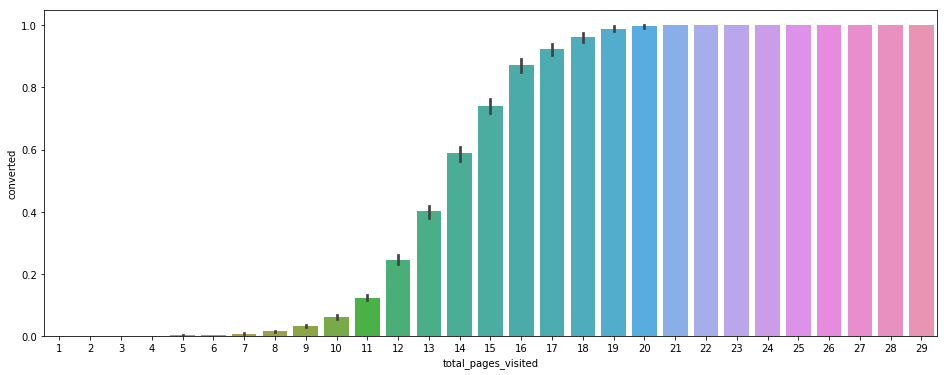

In [10]:
plt.figure(figsize=(16, 6))
sns.barplot(x='total_pages_visited', y='converted', data=conversion_data);

The threshold of conversion > 80% is when people visited 16 pages or more.

***

## Look at the conversion rate by source

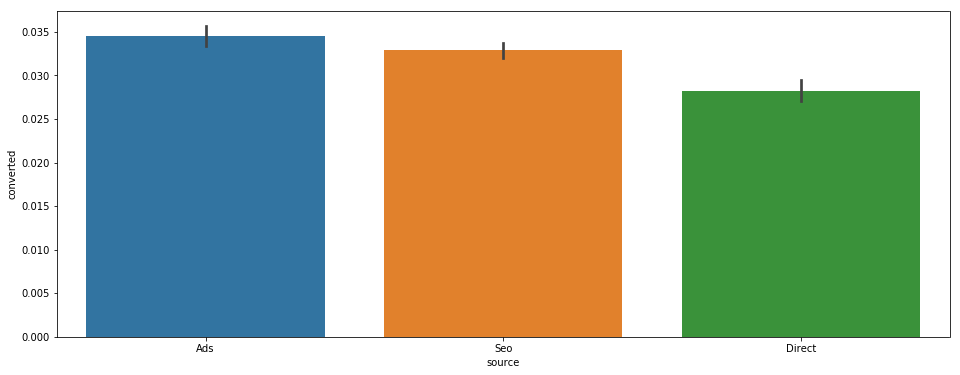

In [11]:
plt.figure(figsize=(16, 6))
sns.barplot(x='source', y='converted', data=conversion_data);

The sources don't seem to have significance different impacts on the convertion rate.

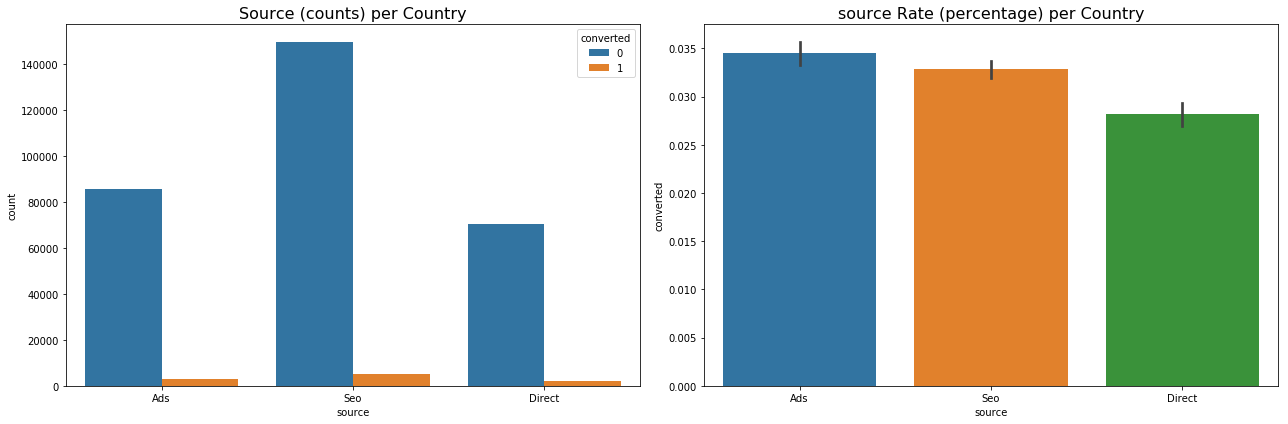

In [108]:
# create a fig with 1 row and 2 colns
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(18, 6))
sns.countplot(x='source', hue='converted', data = conversion_data, ax = ax[0])
ax[0].set_title('Source (counts) per Country', fontsize=16)
sns.barplot(x='source', y='converted', data=conversion_data, ax= ax[1])
ax[1].set_title('source Rate (percentage) per Country', fontsize=16)
plt.tight_layout()
plt.show()

***

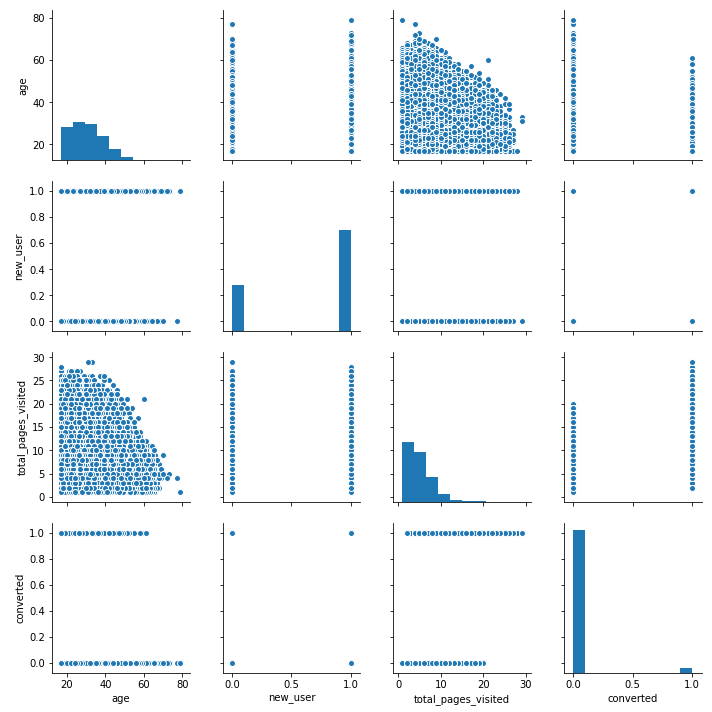

In [12]:
sns.pairplot(conversion_data);

We can there's a **negative correlation** between age and the total pages visited. 

Which means, as age goes up, the number of total pages visited goes down, and vice versa

***

# Building predictive model - Logistic

Since we have easy interpretable variables, we will want to use an easy interpretable model to make interpretations of our results too. So, we pick the basic logistic regression model to start with.

## Feature engineering 

In [14]:
# iloc is by index of the row
# loc is by label of the row
# loc[:, ('column name')] - all rows under this column

X = conversion_data.loc[:,('country', 'age', 'new_user', 'source', 'total_pages_visited')]
X = pd.get_dummies(X)# OHE those categorical features

In [15]:
X.head()

,age,new_user,total_pages_visited,country_China,country_Germany,country_UK,country_US,source_Ads,source_Direct,source_Seo
0,25,1,1,0,0,1,0,1,0,0
1,23,1,5,0,0,0,1,0,0,1
2,28,1,4,0,0,0,1,0,0,1
3,39,1,5,1,0,0,0,0,0,1
4,30,1,6,0,0,0,1,0,0,1


In [16]:
y = conversion_data["converted"]

In [17]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30)

In [18]:
# Cs: smaller values specify stronger regularization
# np.logspace -> [.001, .01, ....., 100, 1000]
# Prefer dual=False when n_samples > n_features
# n_jobs -> -1 means using all processors
# penality -> L2 (Ridge regularization: "squared magnitude -> will not shrink coefficients all the way to zero")


log_model = LogisticRegressionCV(Cs = np.logspace(-3,3,7),
                            dual=False,
                            scoring='roc_auc',
                            max_iter=1000,
                            n_jobs=-1,
                            verbose=1)
log_model.fit(X_train, y_train)

[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    6.3s finished


LogisticRegressionCV(Cs=array([1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03]),
           class_weight=None, cv=None, dual=False, fit_intercept=True,
           intercept_scaling=1.0, max_iter=1000, multi_class='ovr',
           n_jobs=-1, penalty='l2', random_state=None, refit=True,
           scoring='roc_auc', solver='lbfgs', tol=0.0001, verbose=1)

In [48]:
log_model.get_params()

{'Cs': array([1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03]),
 'class_weight': None,
 'cv': None,
 'dual': False,
 'fit_intercept': True,
 'intercept_scaling': 1.0,
 'max_iter': 1000,
 'multi_class': 'ovr',
 'n_jobs': -1,
 'penalty': 'l2',
 'random_state': None,
 'refit': True,
 'scoring': 'roc_auc',
 'solver': 'lbfgs',
 'tol': 0.0001,
 'verbose': 1}

In [19]:
# score for training data 
log_model.score(X_train, y_train)

0.9859987891821558

In [20]:
# score for testing data 
log_model.score(X_test, y_test)

0.9865275142314991

In [22]:
y_test_predict = log_model.predict(X_test)

***

# Evaluation

### Classification report (precision, recall, and etc.)

In [49]:
print(classification_report(y_true = y_test, y_pred = y_test_predict, target_names = ['non-converted', 'converted']))

               precision    recall  f1-score   support

non-converted       0.99      1.00      0.99     91859
    converted       0.86      0.69      0.76      3001

  avg / total       0.99      0.99      0.99     94860



F1 Score is the weighted average of Precision and Recall

### Confusion matrix

In [79]:
confusion_matrix(y_true = y_test, y_pred = y_test_predict)

array([[91526,   333],
       [  945,  2056]])

In [80]:
tn, fp, fn, tp = confusion_matrix(y_true = y_test, y_pred = y_test_predict).ravel()

### Accuracy

In [81]:
accuracy  = (tn + tp) / (tn + fp + fn + tp)

In [82]:
accuracy

0.9865275142314991

In [69]:
# number of converted / number of total
# imbalanced class problem
# looking at F1 score is important
np.where(y_train == 1)[0].size/y_train.size

0.032515880689262575

In [70]:
1- y_test.mean()

0.9683639047016657

# Analysis

## Feature importance

In [90]:
log_model.coef_

array([[-0.07622186, -1.74459048,  0.7549921 , -2.71505464,  1.16947608,
         0.87051979,  0.51918081,  0.01480743, -0.16161011, -0.00907528]])

In [92]:
# create a table of features and its coefficients
feat_importances = pd.DataFrame({"name":X_train.columns,"coef":log_model.coef_[0]})
# reorder the columns
feat_importances = feat_importances[['name','coef']]
# changing the values to absolute values
feat_importances['importances'] = np.abs(feat_importances['coef'] )
# sort the columns by importance value
feat_importances.sort_values(by="importances", inplace=True, ascending=False)
feat_importances

,name,coef,importances
3,country_China,-2.715055,2.715055
1,new_user,-1.744590,1.744590
4,country_Germany,1.169476,1.169476
5,country_UK,0.870520,0.870520
2,total_pages_visited,0.754992,0.754992
6,country_US,0.519181,0.519181
8,source_Direct,-0.161610,0.161610
0,age,-0.076222,0.076222
7,source_Ads,0.014807,0.014807
9,source_Seo,-0.009075,0.009075


0. As predicted from the initial visual analysis, the source of the traffic is least important.

1. The factor for which users from China has the highest importance, the negative sign indicates that chinese users are relatively not converted compared to other factors.

2. The new user factor also have a negative effect, meaning new users are less willing to convert. Thus, the marketing team could put more effor on focusing old users.

3. Users from germany has a positive impact on conversion rate. The team can also maintain this positive impact.

4. Total pages visited matters; hence, the team can focus on creating ways to influence the users to view more pages. This makes sense, because the more pages are views, the more engaged the user is; hence, the more likely the user will convert.

## Conclusion

Depends on the goal of the marketing team, if the goal is to increase the overall conversion rate, increasing the number of pages visted and focus on the younger group of audience in Germany, UK, and the US. 

On the other hand, if the goal is to increase the conversion rate evenly in country, then the team can filter out the China portion of the data and investigate further into this filtered set of data.

***

# Other useful resources: 

 - https://github.com/stasi009/TakeHomeDataChallenges
 - https://github.com/JifuZhao/DS-Take-Home